In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import os
import shutil

import numpy as np

import tqdm

import tensorflow as tf
import tensorflow.keras as keras

# tf.functions (the 'graph mode' of tensorflow)

In former versions, graph and state of the graph were separate. With the new version and eager mode, this separation disappears.

To recover performance, one can use `tf.function` to convert a python function into a cached tensorflow graph operation.

In [2]:
@tf.function
def add(a, b):
    print("---> Tracing: add({}, {})".format(a, b))
    return a + b

Calls are cached by:
  - value if Python primitives (int, float, ...)
  - shape and type if tensors
  - object id otherwise

In [3]:
print(add(tf.constant([2., 2.]), tf.constant([2., 2.])))

---> Tracing: add(Tensor("a:0", shape=(2,), dtype=float32), Tensor("b:0", shape=(2,), dtype=float32))
tf.Tensor([4. 4.], shape=(2,), dtype=float32)


In [4]:
# now the graph is cached, no print statement
print(add(tf.constant([7., 7.]), tf.constant([2., 2.])))

tf.Tensor([9. 9.], shape=(2,), dtype=float32)


In [5]:
print(add("x", "y"))

---> Tracing: add(x, y)
tf.Tensor(b'xy', shape=(), dtype=string)


In [6]:
print(add(1, 2))

---> Tracing: add(1, 2)
tf.Tensor(3, shape=(), dtype=int32)


In [7]:
# primitives: call is now cached
print(add(1, 2))

tf.Tensor(3, shape=(), dtype=int32)


In [8]:
print(add(2, 2))

---> Tracing: add(2, 2)
tf.Tensor(4, shape=(), dtype=int32)


One can also a priori specify which arguments to expect in a tf.function

In [11]:
@tf.function(input_signature=(tf.TensorSpec(shape=(2,), dtype=tf.int32), 
                              tf.TensorSpec(shape=(2,), dtype=tf.int32)))
def add(a, b):
    return a + b

In [14]:
print(add(tf.constant([2, 2]), tf.constant([3, 3])))

tf.Tensor([5 5], shape=(2,), dtype=int32)


If you want to print every time a tf.function is called, use the `tf.print`-operation

In [15]:
@tf.function
def add(a, b):
    print("---> (normal print) Tracing: add({}, {})".format(a, b))
    tf.print("---> (tf print) add({}, {})".format(a, b))
    return a + b

In [16]:
print(add(tf.constant(1.), tf.constant(1.)))
print(add(tf.constant(1.), tf.constant(1.)))

---> (normal print) Tracing: add(Tensor("a:0", shape=(), dtype=float32), Tensor("b:0", shape=(), dtype=float32))
---> (tf print) add(Tensor("a:0", shape=(), dtype=float32), Tensor("b:0", shape=(), dtype=float32))
tf.Tensor(2.0, shape=(), dtype=float32)
---> (tf print) add(Tensor("a:0", shape=(), dtype=float32), Tensor("b:0", shape=(), dtype=float32))
tf.Tensor(2.0, shape=(), dtype=float32)


#### Functions with variables

This would behave differently in eager mode vs graph mode:
  - in eager mode, a new variable is created in each call
  - in graph mode, the variable would be reused until the graph is retraced
  
Therefore, variables cannot be created within `tf.function`-decorated methods.

In [17]:
# eager mode

def f(x):
    v = tf.Variable(1.)
    v.assign_add(x)
    return v

print(f(1.))
print(f(2.))

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=2.0>
<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=3.0>


In [18]:
# graph mode

@tf.function
def f(x):
    v = tf.Variable(1.)
    v.assign_add(x)
    return v

# this is forbidden
print(f(1.))

ValueError: in converted code:

    <ipython-input-18-5f9381bd9638>:5 f  *
        v = tf.Variable(1.)
    /home/mho/miniconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/ops/variables.py:262 __call__
        return cls._variable_v2_call(*args, **kwargs)
    /home/mho/miniconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/ops/variables.py:256 _variable_v2_call
        shape=shape)
    /home/mho/miniconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/ops/variables.py:60 getter
        return captured_getter(captured_previous, **kwargs)
    /home/mho/miniconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/eager/def_function.py:364 invalid_creator_scope
        "tf.function-decorated function tried to create "

    ValueError: tf.function-decorated function tried to create variables on non-first call.


Variables can (due to tracing) only be created once. Making them global circumvents that problem but changes behavior compared to eager mode.

In [19]:
v = tf.Variable(1.0)

@tf.function
def f(x):
    return v.assign_add(x)

print(f(1.))
print(f(2.))

tf.Tensor(2.0, shape=(), dtype=float32)
tf.Tensor(4.0, shape=(), dtype=float32)


The eager mode behavior can be generalized and recovered with object orientation:

In [20]:
class F(object):
    def __init__(self):
        self.v = None
    
    @tf.function
    def __call__(self, x):
        if self.v is None:
            self.v = tf.Variable(1.)
        self.v.assign_add(x)
        return self.v
    
f = F()
print(f(1.))
print(f(1.))
f = F()
print(f(1.))

tf.Tensor(2.0, shape=(), dtype=float32)
tf.Tensor(3.0, shape=(), dtype=float32)
tf.Tensor(2.0, shape=(), dtype=float32)


`tf.function` calling a eager function results in the eager function being also converted to graph operations

In [21]:
def eager_add(x, y):
    print("tracing test")
    return x + y

@tf.function
def test(x, y):
    return eager_add(x, y)

# this traces eager_add only once
print("graph mode:")
print(test(tf.constant(1.), tf.constant(2.)))
print(test(tf.constant(1.), tf.constant(3.)))

print("\neager mode:")
# this traces eager_add eagerly
print(eager_add(tf.constant(1.), tf.constant(2.)))
print(eager_add(tf.constant(1.), tf.constant(3.)))

graph mode:
tracing test
tf.Tensor(3.0, shape=(), dtype=float32)
tf.Tensor(4.0, shape=(), dtype=float32)

eager mode:
tracing test
tf.Tensor(3.0, shape=(), dtype=float32)
tracing test
tf.Tensor(4.0, shape=(), dtype=float32)


There are some more subtleties concerning loops (see, e.g., `tf.range`) and conditionals (see, e.g., `tf.cond`). A comprehensive guide can be found here: https://www.tensorflow.org/beta/tutorials/eager/tf_function

# Visualizing graph and training with Tensorboard

In [22]:
# start with a clean plate
shutil.rmtree('logs/', ignore_errors=True)

In [23]:
# create a writer
writer = tf.summary.create_file_writer('logs/test')

### Tracing graphs

In [24]:
@tf.function
def my_func(x, y):
    # A simple hand-rolled layer.
    return tf.nn.relu(tf.matmul(x, y))

x = tf.random.normal((3, 3))
y = tf.random.normal((3, 3))

tf.summary.trace_on(graph=True)
out = my_func(x, y)
with writer.as_default():   
    tf.summary.trace_export(
        name='my_func_trace',
        step=0
    )
tf.summary.trace_off()

### Visualizing scalar properties

In [25]:
xs = np.linspace(0, 4, num=10000)
ys = xs**2
ys2 = xs**3

for i in tqdm.tqdm_notebook(range(len(xs))):
    with writer.as_default():
        tf.summary.scalar('train/xsquared', ys[i], step=i)
        tf.summary.scalar('train/xcubed', ys2[i], step=i)
        tf.summary.scalar('test/x', xs[i], step=i)

### Visualizing histograms

In [26]:
@tf.function
def mean_moving_normal(mean):
    return tf.random.normal(shape=[1000], mean=mean, stddev=1)

for i in range(500):
    normals = mean_moving_normal(tf.constant(i / 100))
    with writer.as_default():
        tf.summary.histogram('normals', normals, step=i)

Tensorboard can be started with `tensorboard --logdir /path/to/the/logs --port 6006` and opened in the browser under `localhost:6006`.

# MNIST variational autoencoder

![title](figures/vae.png)


Kullback Leibler divergence:
$$
L_{\mathrm{KL}} = D_{\text{KL}}(P \,\|\, Q) := -\sum_i P(i)\log \frac{Q(i)}{P(i)}
$$
In case of a VAE:
$$
D_\text{KL}(\mathcal{N}(\mu, \Sigma) \,\|\, \mathcal{N}(0,1))
$$

And a suitable reconstruction loss (e.g. MSE or cross entropy).

Altogether:

$$
L = -\mathbb{E}_{z\sim q_\Theta (z | x)}(\log\underbrace{ p_\Lambda(x | z)}_{\text{Decoder}}) + D_\text{KL}(\underbrace{q_\Theta(z | x)}_{\text{Encoder}}\,\|\, p(z))
$$

In [27]:
class InferenceNet(keras.Model):
    
    def __init__(self, latent_dim, **kw):
        super(InferenceNet, self).__init__(**kw)
        
        self.latent_dim = latent_dim
        
        self.flatten = tf.keras.layers.Flatten()
        
        self.dense1 = tf.keras.layers.Dense(25*25, activation=tf.nn.leaky_relu)
        self.dense2 = tf.keras.layers.Dense(15*15, activation=tf.nn.leaky_relu)
        self.dense3 = tf.keras.layers.Dense(8*8, activation=tf.nn.leaky_relu)
                
        self.to_mean = keras.layers.Dense(latent_dim, activation=None, name="to_mean")
        self.to_logvar = keras.layers.Dense(latent_dim, activation=None, name="to_logvar")
        
    @tf.function
    def call(self, inputs, training=None):
        out = self.flatten(inputs)
        out = self.dense3(self.dense2(self.dense1(out)))
        
        mean = self.to_mean(out)
        logvar = self.to_logvar(out)
        return mean, logvar

In [28]:
class GenerativeNet(keras.Model):
    
    def __init__(self, **kw):
        super(GenerativeNet, self).__init__(**kw)
        
        self.dense1 = tf.keras.layers.Dense(8*8, activation=tf.nn.leaky_relu)
        self.dense2 = tf.keras.layers.Dense(15*15, activation=tf.nn.leaky_relu)
        self.dense3 = tf.keras.layers.Dense(28 * 28, activation=tf.nn.leaky_relu)
        
        self.reshape = tf.keras.layers.Reshape([28, 28, 1])
        
    @tf.function
    def call(self, inputs, training=None):
        out = self.dense3(self.dense2(self.dense1(inputs)))
        out = self.reshape(out)
        return out

__Variational autoencoder model__:

Has an inference net (encoder) and a generative net (decoder). Data is first projected onto mean and variance (inference net) and then reparameterized into the latent variable $z$. The latent variable is decoded back into the reconstruction in the full space.

*Methods*:
- `encode(data, training=None)`: encodes `data` into mean and log variance in prediction mode or training mode
- `reparameterize(mean, logvar)`: reparameterizes $r\sim \mathcal{N}(0,1)$ to $z = \mu + \sqrt{\exp{\log \sigma^2}}r$
- `decode(z, training=None)`: decodes a latent variable $z$
- `sample(z=None)`: generates new samples optionally based on latent variable $z$
- `call(inputs, training=None)`: chained encoding, reparameterizing, decoding
- `compute_loss(x, training=None)`: computes the loss for a batch of data `x`
- `compute_apply_gradients(x, optimizer)`: computes and applies gradients, model update

In [29]:
class VAE(keras.Model):
    
    def __init__(self, latent_dim, *args, **kw):
        super(VAE, self).__init__(*args, **kw)
        
        self.latent_dim = latent_dim
        self.inference_net = InferenceNet(self.latent_dim, name="Encoder")
        self.generative_net = GenerativeNet(name="Decoder")
        
    @tf.function
    def encode(self, x, training=None):
        return self.inference_net(x, training=training)

    @tf.function
    def reparameterize(self, mean, logvar):
        with tf.name_scope("reparameterize"):
            rnd = tf.random.normal(shape=tf.shape(mean))
            z = rnd * tf.exp(logvar * .5) + mean
        return z

    @tf.function
    def decode(self, z, training=None):
        return self.generative_net(z, training=training)
    
    @tf.function
    def sample(self, z=None):
        with tf.name_scope("sample"):
            if z is None:
                z = tf.random.normal(shape=(100, self.latent_dim))
            output = self.decode(z, training=False)
        return output
    
    @tf.function
    def call(self, inputs, training=None):
        mean, logvar = self.encode(inputs, training=training)
        z = self.reparameterize(mean, logvar)
        output = self.decode(z, training=training)
        return output
    
    @tf.function
    def compute_loss(self, x, training=None):
        with tf.name_scope("vae_loss"):
            mean, logvar = self.encode(x, training=training)
            z = self.reparameterize(mean, logvar)
            x_logit = self.decode(z, training=training)
            
            reconstruction_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
            
            with tf.name_scope("KL"):
                kl = -.5 * tf.reduce_sum(1 + logvar - tf.square(mean) - tf.exp(logvar), axis=1)
            loss = tf.reduce_mean(kl + tf.reduce_sum(reconstruction_loss, axis=[1, 2, 3]))
        return loss
    
    @tf.function
    def compute_apply_gradients(self, x, optimizer):
        with tf.GradientTape() as tape:
            loss = self.compute_loss(x)
        gradients = tape.gradient(loss, self.trainable_variables)
        optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        return loss

In [30]:
optimizer = tf.keras.optimizers.Adam(5e-4)

In [31]:
latent_dim = 50

In [32]:
model = VAE(latent_dim)

In [33]:
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = np.array(x_train, dtype=np.float32)
x_test = np.array(x_test, dtype=np.float32)

In [34]:
train_ds = tf.data.Dataset.from_tensor_slices(x_train)\
            .map(lambda x: tf.expand_dims(x, -1)).shuffle(1024).batch(512)
test_ds = tf.data.Dataset.from_tensor_slices(x_test)\
            .map(lambda x: tf.expand_dims(x, -1)).batch(1024)

In [35]:
train_losses = []
test_losses = []

for epoch in tqdm.tqdm_notebook(range(50)):
    train_loss = tf.keras.metrics.Mean()
    for x in train_ds:
        l = model.compute_apply_gradients(x, optimizer)
        train_loss(l)
    train_losses.append(train_loss.result())
        
    test_loss = tf.keras.metrics.Mean()
    for test_x in test_ds:
        test_loss(model.compute_loss(test_x))
    test_losses.append(test_loss.result())
        
    print('Epoch: {}, Train loss: {}, Test loss: {}'.format(epoch + 1, train_loss.result(), 
                                                            test_loss.result()))

W0821 16:38:27.996334 140529000683328 deprecation.py:323] From /home/mho/miniconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:182: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch: 1, Train loss: 322.5368957519531, Test loss: 215.3136444091797
Epoch: 2, Train loss: 211.5949249267578, Test loss: 209.96450805664062
Epoch: 3, Train loss: 207.25819396972656, Test loss: 202.68357849121094
Epoch: 4, Train loss: 198.41148376464844, Test loss: 192.07577514648438
Epoch: 5, Train loss: 188.47108459472656, Test loss: 183.52163696289062
Epoch: 6, Train loss: 178.6939239501953, Test loss: 173.9482879638672
Epoch: 7, Train loss: 171.46022033691406, Test loss: 168.49134826660156
Epoch: 8, Train loss: 166.4633026123047, Test loss: 163.7617950439453
Epoch: 9, Train loss: 161.83999633789062, Test loss: 158.90501403808594
Epoch: 10, Train loss: 157.8690185546875, Test loss: 155.43521118164062
Epoch: 11, Train loss: 154.49154663085938, Test loss: 152.22132873535156
Epoch: 12, Train loss: 151.58950805664062, Test loss: 149.67784118652344
Epoch: 13, Train loss: 149.05767822265625, Test loss: 146.89938354492188
Epoch: 14, Train loss: 146.58456420898438, Test loss: 144.6437530517

KeyboardInterrupt: 

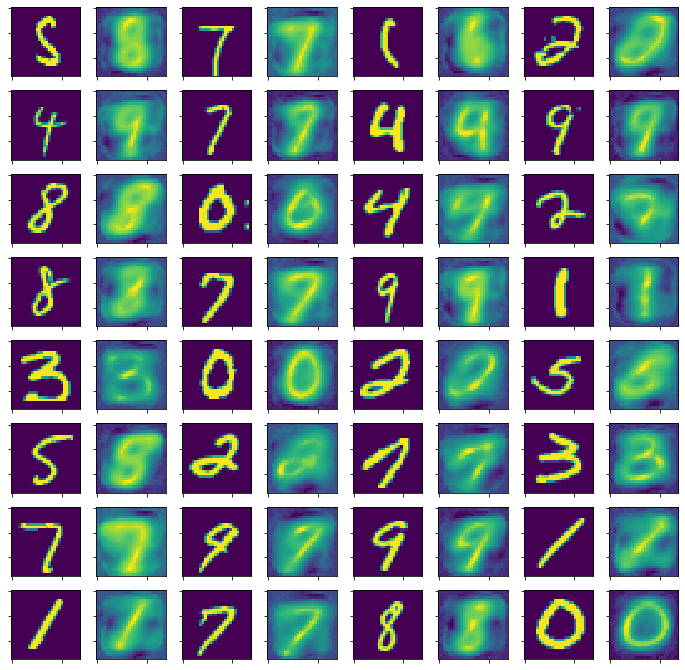

In [36]:
for images in train_ds.take(1):
    images = images[:8*4]
    n_images = len(images)
    n_cols = 8
    n_rows = 2*n_images // n_cols
    
    fig, axes = plt.subplots(n_rows,n_cols, figsize=(n_cols*1.5,n_rows*1.5))
    axes = axes.flatten()
    
    predictions = model(images)
    
    for i, image in enumerate(images):
        axes[2*i].imshow(image.numpy().squeeze())
        axes[2*i].set_yticklabels([])
        axes[2*i].set_xticklabels([])
        axes[2*i+1].imshow(predictions[i].numpy().squeeze())
        axes[2*i+1].set_yticklabels([])
        axes[2*i+1].set_xticklabels([])

# The swiss roll jump process

![title](./figures/swiss-roll-process.png)
![title](figures/tae.png)
<cite>Wehmeyer, Noé, (2018). Time-lagged autoencoders: Deep learning of slow collective variables for molecular kinetics. J. Chem. Phys., 148(24), 241703.</cite>

In [37]:
with open("dimredux-challenge.npz", "rb") as f:
    X = np.load(f)
    data = X['data']
    dtraj = X['dtraj']
    
print("got data with shape {}".format(data.shape))

got data with shape (100000, 3)


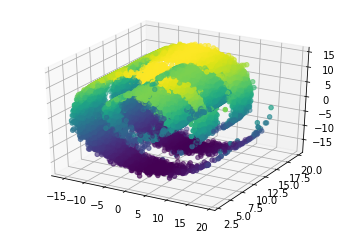

In [38]:
f = plt.figure()
ax = f.add_subplot(111, projection='3d')
ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=data[:, 2]);

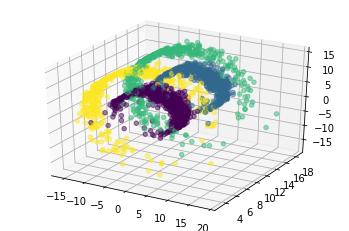

In [39]:
f = plt.figure()
ax = f.add_subplot(111, projection='3d')
stride=50
ax.scatter(*(data[::stride].T), c=dtraj[::stride]/np.max(dtraj), alpha=.5);

## General hyperparameters

In [40]:
batch_size = 256
n_epochs = 25

## The activation

In [41]:
@tf.function
def swish(x):
    return x * tf.nn.sigmoid(x)

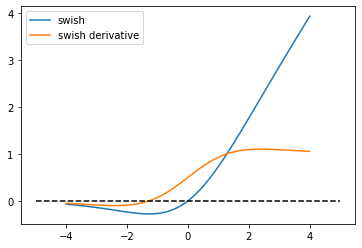

In [42]:
xs = tf.linspace(-4., 4., 50)
with tf.GradientTape() as tape:
    # xs is not trainable so we need to watch it
    tape.watch(xs)
    ys = swish(xs)
dys_dxs = tape.gradient(ys, xs)

plt.plot(xs, ys, label='swish')
plt.plot(xs, dys_dxs, label='swish derivative')
plt.plot(np.linspace(-5, 5, num=50), np.zeros((50,)), 'k--')
plt.legend();

## Create datasets

In [43]:
dataset = tf.data.Dataset.from_tensor_slices((data[:-1].astype(np.float32), data[1:].astype(np.float32)))

In [45]:
n_val = int(len(data) * .1)
ds_test = dataset.take(n_val).batch(batch_size)
ds_val = dataset.skip(n_val).take(n_val).batch(batch_size)
ds_train = dataset.skip(2*n_val).shuffle(1000).batch(batch_size)

## Define the model

In [46]:
class InferenceNet(keras.Model):
    
    def __init__(self, latent_dim, **kw):
        super(InferenceNet, self).__init__(**kw)
        
        self.latent_dim = latent_dim
        self.activation = keras.layers.Lambda(lambda x: swish(x), name="swish")
        
        self.dense1 = keras.layers.Dense(300, name="dense1")
        self.dropout1 = keras.layers.Dropout(rate=0.2, name="dropout1")
        
        self.dense2 = keras.layers.Dense(150, name="dense2")
        self.dropout2 = keras.layers.Dropout(rate=0.2, name="dropout2")
        
        self.to_mean = keras.layers.Dense(latent_dim, activation=None, name="to_mean")
        self.to_logvar = keras.layers.Dense(latent_dim, activation=None, name="to_logvar")
        
    def call(self, inputs, training=None):
        out = self.dense1(inputs)
        out = self.activation(out)
        out = self.dropout1(out, training=training)
        
        out = self.dense2(out)
        out = self.activation(out)
        out = self.dropout2(out, training=training)
        
        mean = self.to_mean(out)
        logvar = self.to_logvar(out)
        return mean, logvar

In [47]:
class GenerativeNet(keras.Model):
    
    def __init__(self, **kw):
        super(GenerativeNet, self).__init__(**kw)
        
        self.activation = keras.layers.Lambda(lambda x: swish(x), name="swish")
        
        self.dense1 = keras.layers.Dense(150, name="dense1")
        self.dropout1 = keras.layers.Dropout(rate=0.2, name="dropout1")
        self.dense2 = keras.layers.Dense(300, name="dense2")
        self.dropout2 = keras.layers.Dropout(rate=0.2, name="dropout2")
        self.dense3 = keras.layers.Dense(3, name="dense3")
        
    def call(self, inputs, training=None):
        out = self.activation(self.dense1(inputs))
        out = self.dropout1(out, training=training)
        out = self.activation(self.dense2(out))
        out = self.dropout2(out, training=training)
        out = self.dense3(out)
        return out

In [48]:
class TVAE(keras.Model):
    
    def __init__(self, latent_dim, *args, **kw):
        super(TVAE, self).__init__(*args, **kw)
        
        self.latent_dim = latent_dim
        self.inference_net = InferenceNet(self.latent_dim, name="Encoder")
        self.generative_net = GenerativeNet(name="Decoder")
        
    @tf.function
    def sample(self, z=None):
        with tf.name_scope("sample"):
            if z is None:
                z = tf.random.normal(shape=(100, self.latent_dim))
            output = self.decode(z, apply_sigmoid=True, training=False)
        return output
    
    def encode(self, x, training=True):
        return self.inference_net(x, training=training)

    def reparameterize(self, mean, logvar):
        with tf.name_scope("reparameterize"):
            eps = tf.random.normal(shape=tf.shape(mean))
            z = eps * tf.exp(logvar * .5) + mean
        return z

    def decode(self, z, apply_sigmoid=False, training=None):
        logits = self.generative_net(z, training=training)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits
    
    def call(self, inputs, training=None):
        mean, logvar = self.encode(inputs, training=training)
        z = self.reparameterize(mean, logvar)
        output = self.decode(z, training=training)
        return output
    
    @tf.function
    def compute_loss(self, x, x_lagged, training=None):
        with tf.name_scope("vae_loss"):
            mean, logvar = self.encode(x, training=training)
            z = self.reparameterize(mean, logvar)
            x_logit = self.decode(z, training=training)

            reconstruction_loss = keras.losses.MeanSquaredError()(x_lagged, x_logit)
            
            with tf.name_scope("KL"):
                kl = -.5 * tf.reduce_sum(1 + logvar - tf.square(mean) - tf.exp(logvar), axis=1)
            loss = kl + tf.reduce_mean(reconstruction_loss)
        return loss
    
    @tf.function
    def compute_apply_gradients(self, x, x_lagged, optimizer):
        with tf.GradientTape() as tape:
            loss = self.compute_loss(x, x_lagged)
        gradients = tape.gradient(loss, self.trainable_variables)
        optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        return loss

In [49]:
optimizer = tf.keras.optimizers.Adam(1e-3)

In [50]:
model = TVAE(1)

In [51]:
train_losses = []
val_losses = []

In [52]:
for epoch in tqdm.tqdm_notebook(range(n_epochs)):
    train_loss = tf.keras.metrics.Mean()
    for x, x_lagged in ds_train:
        batch_loss = model.compute_apply_gradients(x, x_lagged, optimizer)
        train_loss(batch_loss)
    train_losses.append(train_loss.result())
    
    val_loss = tf.keras.metrics.Mean()
    for val_x, val_x_lagged in ds_val:
        val_loss(model.compute_loss(val_x, val_x_lagged, training=False))
    val_losses.append(val_loss.result())
    
    print('Epoch: {}, Train loss: {}, Val loss: {}'
          .format(epoch + 1, train_loss.result(), val_loss.result()))

Epoch: 1, Train loss: 42.3011589050293, Val loss: 42.023746490478516
Epoch: 2, Train loss: 36.35823059082031, Val loss: 40.11272048950195
Epoch: 3, Train loss: 34.2899284362793, Val loss: 38.25684356689453
Epoch: 4, Train loss: 33.4493408203125, Val loss: 37.74024963378906
Epoch: 5, Train loss: 33.05839920043945, Val loss: 37.35506057739258
Epoch: 6, Train loss: 32.89377975463867, Val loss: 37.232120513916016
Epoch: 7, Train loss: 32.80488586425781, Val loss: 37.251861572265625
Epoch: 8, Train loss: 32.74125671386719, Val loss: 37.04256057739258
Epoch: 9, Train loss: 32.65922927856445, Val loss: 36.99152755737305
Epoch: 10, Train loss: 32.595664978027344, Val loss: 36.89591598510742
Epoch: 11, Train loss: 32.554832458496094, Val loss: 36.837467193603516
Epoch: 12, Train loss: 32.527976989746094, Val loss: 36.826202392578125
Epoch: 13, Train loss: 32.474578857421875, Val loss: 36.86921691894531
Epoch: 14, Train loss: 32.48170852661133, Val loss: 36.846038818359375
Epoch: 15, Train loss:

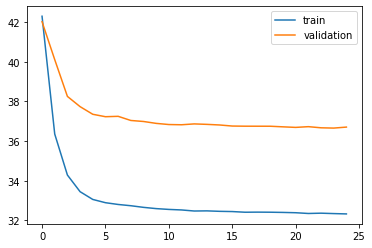

In [53]:
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="validation")
plt.legend();

In [54]:
zs = []
for X, Y in ds_test:
    mu, logvar = model.encode(X, training=False)
    z = model.reparameterize(mu, logvar)
    zs.append(z.numpy().squeeze())
z = np.concatenate(zs)

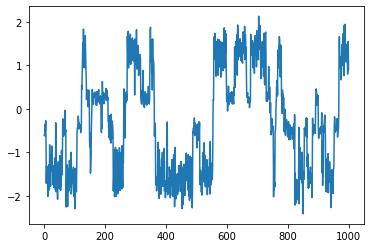

In [55]:
plt.plot(z[:1000])

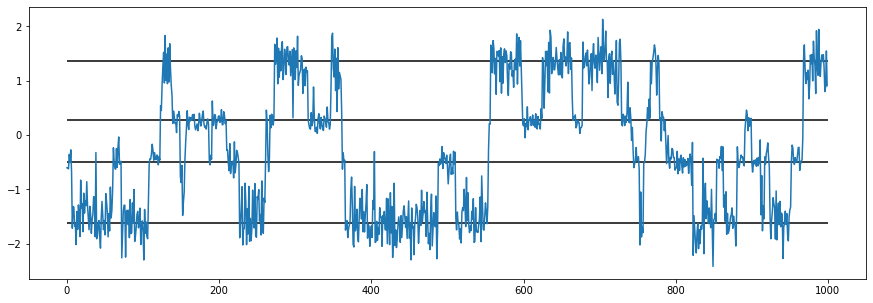

In [56]:
from sklearn.cluster import KMeans
cc = KMeans(n_clusters=4).fit(z[:, None]).cluster_centers_

f, ax = plt.subplots(1,1,figsize=(15, 5))
ax.plot(z[:1000])
ax.hlines(cc, xmin=0, xmax=1000)

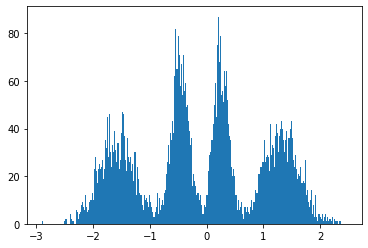

In [57]:
plt.hist(z, bins=500);

# Writing graph and training progress to tensorboard

In [58]:
n_epochs = 50

In [59]:
train_log_dir = 'logs/swissroll/train'
val_log_dir = 'logs/swissroll/val'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
val_summary_writer = tf.summary.create_file_writer(val_log_dir)

In [60]:
optimizer = tf.keras.optimizers.Adam(1e-3)

In [61]:
model = TVAE(2)

In [62]:
y = tf.random.normal(shape=(100, 3))
yrec = tf.random.normal(shape=(100, 3))

tf.summary.trace_on(graph=True)
l = model.compute_loss(y, yrec)
with train_summary_writer.as_default():   
    tf.summary.trace_export(
        name='tvae2_graph',
        step=0
    )

tf.summary.trace_off()

In [63]:
checkpoint_dir = 'logs/ckpt/'
checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)
checkpoint_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=2)
checkpoint.restore(checkpoint_manager.latest_checkpoint);

In [64]:
for epoch in tqdm.tqdm_notebook(range(n_epochs)):
    train_loss = tf.keras.metrics.Mean()
    for x, x_lagged in ds_train:
        l = model.compute_apply_gradients(x, x_lagged, optimizer)
        train_loss(l)
        
    with train_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss.result(), step=epoch)
    
    val_loss = tf.keras.metrics.Mean()
    for val_x, val_x_lagged in ds_val:
        val_loss(model.compute_loss(val_x, val_x_lagged))
    with val_summary_writer.as_default():
        tf.summary.scalar('loss', val_loss.result(), step=epoch)
    
    checkpoint_manager.save()
    
    print('Epoch: {}, Train loss: {}, Val loss: {}'.format(epoch + 1, train_loss.result(), val_loss.result()))

Epoch: 1, Train loss: 38.71574401855469, Val loss: 38.887054443359375
Epoch: 2, Train loss: 34.13283157348633, Val loss: 38.28361892700195
Epoch: 3, Train loss: 33.76560974121094, Val loss: 38.03551483154297
Epoch: 4, Train loss: 33.68733596801758, Val loss: 37.98911666870117
Epoch: 5, Train loss: 33.48453903198242, Val loss: 37.86077880859375
Epoch: 6, Train loss: 33.3568115234375, Val loss: 37.73812484741211
Epoch: 7, Train loss: 33.24559020996094, Val loss: 37.574764251708984
Epoch: 8, Train loss: 33.06338119506836, Val loss: 37.344383239746094
Epoch: 9, Train loss: 32.815067291259766, Val loss: 37.240787506103516
Epoch: 10, Train loss: 32.73232650756836, Val loss: 37.07630157470703
Epoch: 11, Train loss: 32.66480255126953, Val loss: 37.101104736328125
Epoch: 12, Train loss: 32.63386535644531, Val loss: 37.02812957763672
Epoch: 13, Train loss: 32.64780044555664, Val loss: 37.04182815551758
Epoch: 14, Train loss: 32.61723327636719, Val loss: 37.023624420166016
Epoch: 15, Train loss: 

In [75]:
zs = []
for X, Y in ds_test:
    mu, logvar = model.encode(X, training=False)
    z = model.reparameterize(mu, logvar)
    zs.append(z.numpy().squeeze())
z = np.concatenate(zs)

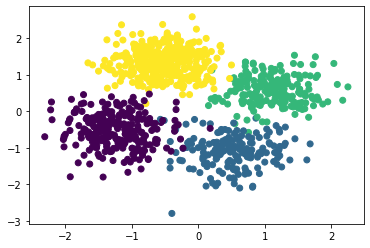

In [76]:
plt.scatter(z[:1000, 0], z[:1000, 1], c=dtraj[:1000] / np.max(dtraj))

In [77]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=4).fit(z)
z_assignments = km.predict(z)

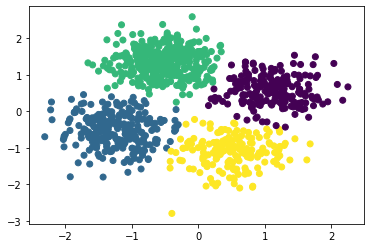

In [78]:
plt.scatter(z[:1000, 0], z[:1000, 1], c=z_assignments[:1000] / np.max(z_assignments))